# Logistic Regression (Tuned and Regularised)
Developed by Zion Knight (s3906411)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

dataFile = 'data/chartEventsPred.csv'

Read in the data

In [2]:
data = pd.read_csv(dataFile)
data.head()

,subject_id,label,charttime,glucose,next_glucose,mean_last3,std_last3,trend,BUN,Creatinine,Diastolic Blood Pressure,Heart Rate,Hemoglobin,Mean Blood Pressure,O2 Saturation,PTT,Respiratory Rate,Sodium,Systolic Blood Pressure,WBC
0,10001217,normal,2157-12-19 22:00:00,145.0,113.0,129.000000,22.627417,32.0,9.500000,0.450000,77.720000,86.711538,11.750000,88.673469,95.019231,32.700000,19.038462,138.5,126.900000,13.70
1,10001725,normal,2110-04-11 18:02:00,146.0,152.0,153.500000,10.606602,-15.0,17.000000,0.800000,61.187500,79.156250,13.250000,70.062500,98.225806,30.600000,17.531250,139.0,100.406250,18.55
2,10001884,normal,2131-01-11 06:37:00,140.0,145.0,144.000000,5.656854,-8.0,26.785714,0.885714,74.669683,70.800000,8.670588,90.529412,97.589286,58.061765,19.044444,136.5,129.176471,12.78
3,10001884,hyper,2131-01-12 03:34:00,145.0,199.0,144.333333,4.041452,5.0,26.785714,0.885714,74.669683,70.800000,8.670588,90.529412,97.589286,58.061765,19.044444,136.5,129.176471,12.78
4,10001884,normal,2131-01-13 04:29:00,199.0,177.0,161.333333,32.715949,54.0,26.785714,0.885714,74.669683,70.800000,8.670588,90.529412,97.589286,58.061765,19.044444,136.5,129.176471,12.78


In [3]:
data.isnull().sum()

subject_id                  0
label                       0
charttime                   0
glucose                     0
next_glucose                0
mean_last3                  0
std_last3                   0
trend                       0
BUN                         0
Creatinine                  0
Diastolic Blood Pressure    0
Heart Rate                  0
Hemoglobin                  0
Mean Blood Pressure         0
O2 Saturation               0
PTT                         0
Respiratory Rate            0
Sodium                      0
Systolic Blood Pressure     0
WBC                         0
dtype: int64

In [4]:
data.shape

(914655, 20)

Clean up missing values and deidentify data

In [5]:
data = data.dropna()
data.isnull().sum()
data.drop(['subject_id', 'charttime', 'next_glucose'], axis=1, inplace=True)
data.shape

(914655, 17)

Data exploration

In [6]:
data.describe()

,glucose,mean_last3,std_last3,trend,BUN,Creatinine,Diastolic Blood Pressure,Heart Rate,Hemoglobin,Mean Blood Pressure,O2 Saturation,PTT,Respiratory Rate,Sodium,Systolic Blood Pressure,WBC
count,914655.000000,914655.000000,914655.000000,914655.000000,914655.000000,914655.000000,914655.000000,914655.000000,914655.000000,914655.000000,914655.000000,914655.000000,914655.000000,914655.000000,914655.000000,914655.000000
mean,144.578997,145.013717,21.774393,-0.404588,24.206049,1.065083,62.462120,85.100259,9.872240,78.801288,96.933580,35.347523,19.601873,138.946948,118.954190,13.588411
std,55.057266,49.459708,22.017058,41.085449,12.172764,0.471067,8.814706,11.384413,1.491851,8.379668,1.329479,9.306082,2.909948,3.450008,12.542660,5.240596
min,20.000000,21.666667,0.000000,-880.000000,1.000000,0.076190,36.975427,46.827586,5.500000,53.450000,92.428571,17.300000,10.452830,129.357143,80.133333,0.100000
25%,110.000000,113.583333,8.962886,-17.000000,14.730769,0.714286,56.285714,77.038462,8.758065,72.727273,96.071147,28.270833,17.484663,136.666667,109.878947,9.872973
50%,132.000000,133.333333,16.010413,-1.000000,21.200000,0.950000,61.846885,84.570455,9.606667,77.774026,97.031707,32.240000,19.441026,138.800000,117.727273,12.727273
75%,164.000000,162.666667,27.392213,16.000000,31.666667,1.325000,67.988372,92.696703,10.725000,84.094118,97.889344,41.023611,21.536960,141.230769,127.176724,16.366667
max,1000.000000,885.333333,584.777308,907.000000,58.000000,2.450000,91.115942,120.666667,15.800000,106.000000,100.414493,59.016667,27.716981,148.000000,158.623188,29.325000


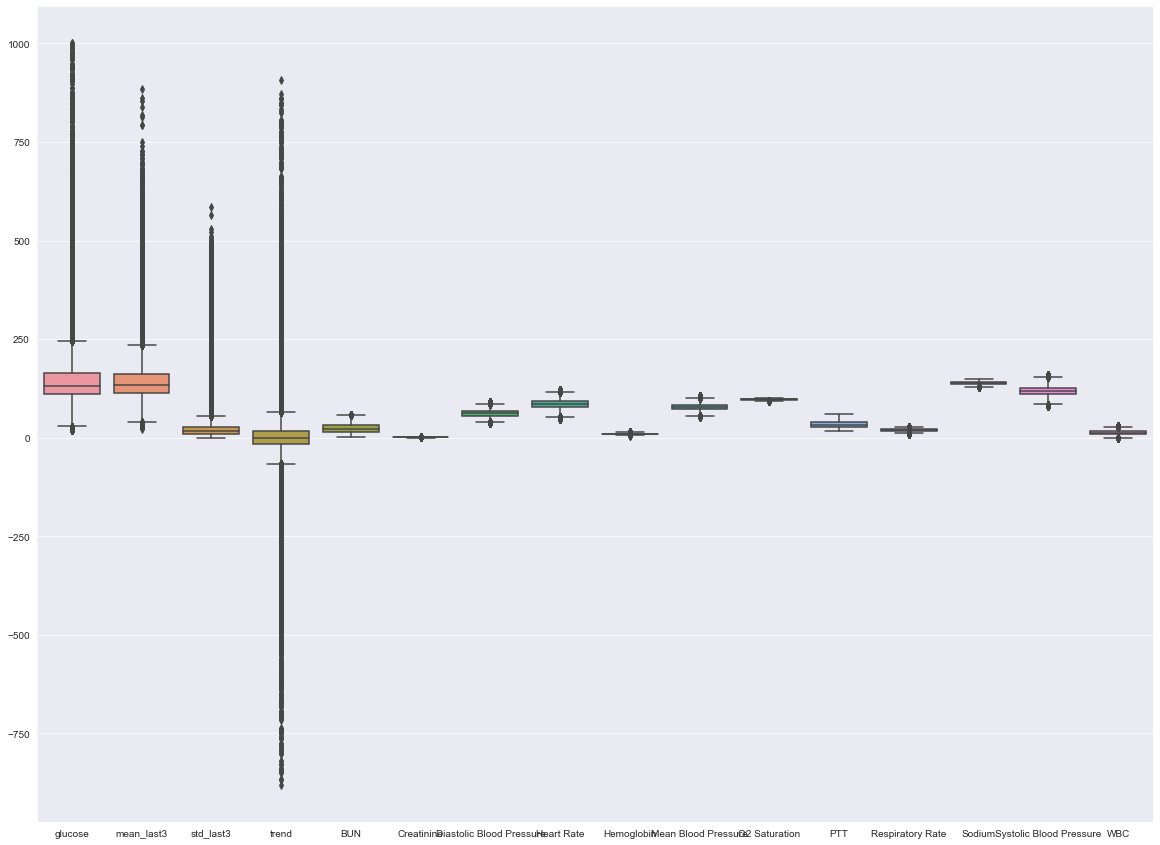

In [7]:
plt.figure(figsize=(20, 15))
sns.boxplot(data=data)
plt.show()

Split tagert and predicting values

In [8]:
y = data['label']
x = data.drop(['label'], axis=1)

Scale data

In [9]:
scaler = StandardScaler()
scaler.fit(x)
x_scaled = scaler.transform(x)

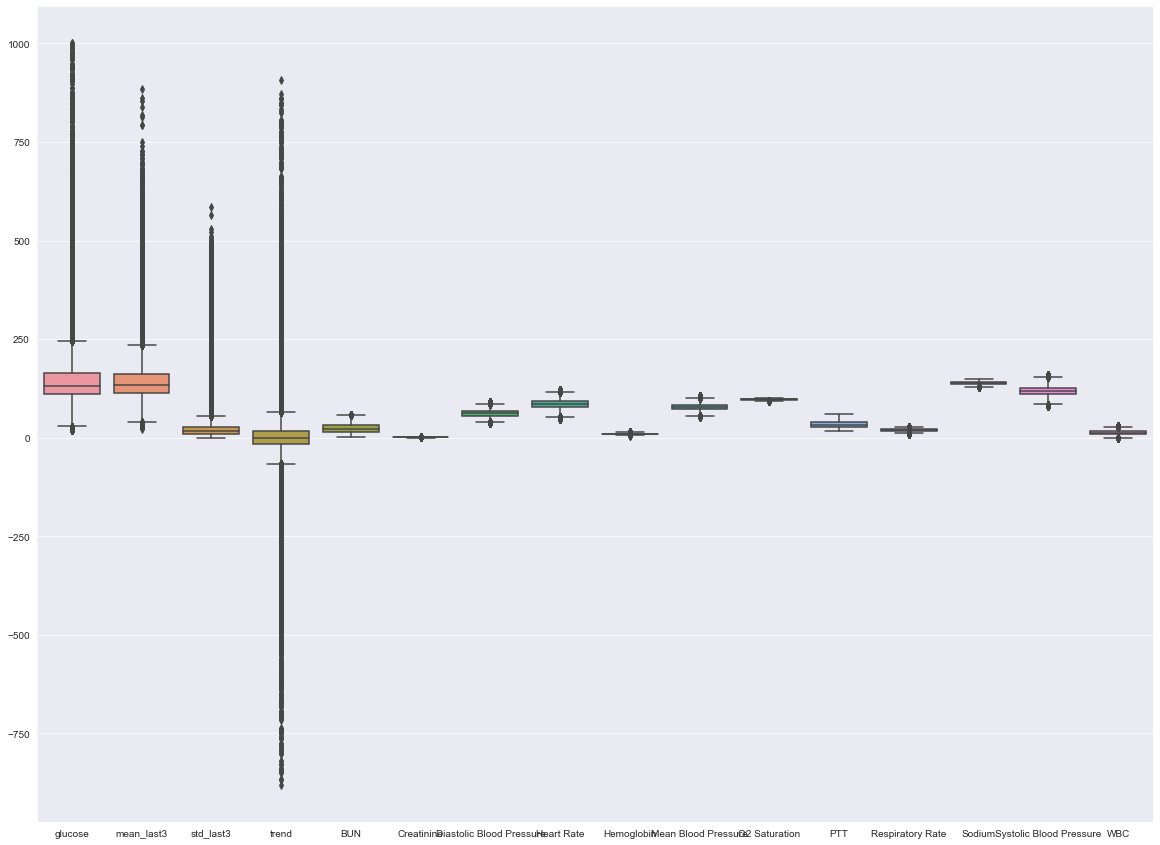

In [10]:
plt.figure(figsize=(20, 15))
sns.boxplot(data=x)
plt.show()

Split training and testing sets

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=1)

Tune the model using validation data (cross-fold)

In [12]:
log_reg = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=1000
)

In [13]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
}

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000,
                                          multi_class='multinomial'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, scoring='accuracy')

Predict using the test set and evaluate performance

In [14]:
model = grid_search.best_estimator_

In [15]:
y_pred = model.predict(x_test)
print("Test Data Classification Report:")
print(classification_report(y_test, y_pred))

Test Data Classification Report:
              precision    recall  f1-score   support

       hyper       0.78      0.49      0.60     32563
        hypo       0.31      0.01      0.02      2401
      normal       0.88      0.97      0.92    147967

    accuracy                           0.87    182931
   macro avg       0.66      0.49      0.52    182931
weighted avg       0.86      0.87      0.86    182931



In [16]:
y_score = model.predict_proba(x_test)
auc = roc_auc_score(y_test, y_score, multi_class='ovr')
print(f"Multiclass ROC AUC (ovr): {auc:.4f}")

Multiclass ROC AUC (ovr): 0.8709


In [17]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[ 15930     11  16622]
 [    66     27   2308]
 [  4374     49 143544]]


Information for result documentation (sample size and features)

In [18]:
print("Columns:")
print(data.columns)
print("Data size:")
print(data.shape)

Columns:
Index(['label', 'glucose', 'mean_last3', 'std_last3', 'trend', 'BUN',
       'Creatinine', 'Diastolic Blood Pressure', 'Heart Rate', 'Hemoglobin',
       'Mean Blood Pressure', 'O2 Saturation', 'PTT', 'Respiratory Rate',
       'Sodium', 'Systolic Blood Pressure', 'WBC'],
      dtype='object')
Data size:
(914655, 17)


In [19]:
print(", ".join(data.columns.tolist()))

label, glucose, mean_last3, std_last3, trend, BUN, Creatinine, Diastolic Blood Pressure, Heart Rate, Hemoglobin, Mean Blood Pressure, O2 Saturation, PTT, Respiratory Rate, Sodium, Systolic Blood Pressure, WBC
